ForGroup : 26194
GroupGal : 83093
StellarMasses : 114685
EnvMeasures : 67996
visualMorph : 38795
Join GroupGal & StellarMasses 43463
GroupGal & StellarMasses
['CATAID', 'RA', 'Dec', 'Z_1', 'Rpetro', 'DM_100_25_75', 'SURVEY_CODE_1', 'SigErr', 'GroupID', 'RankIterCen', 'SepIterCen', 'CoSepIterCen', 'AngSepIterCen', 'RankBCG', 'SepBCG', 'CoSepBCG', 'AngSepBCG', 'RankCen', 'SepCen', 'CoSepCen', 'AngSepCen', 'Z_2', 'nQ', 'SURVEY_CODE_2', 'SURVEY_CLASS', 'Z_TONRY', 'fluxscale', 'zmax_19p8', 'zmax_19p4', 'zmax_19p0', 'zmax_17p8', 'nbands', 'S2N', 'PPP', 'logmstar', 'dellogmstar', 'logmoverl_i', 'dellogmoverl_i', 'logage', 'dellogage', 'logtau', 'dellogtau', 'logmintsfh', 'dellogmintsfh', 'logmremnants', 'dellogmremnants', 'metal', 'delmetal', 'extBV', 'delextBV', 'logLWage', 'dellogLWage', 'gminusi', 'delgminusi', 'uminusr', 'deluminusr', 'gminusi_stars', 'uminusr_stars', 'C_logM_ur', 'C_logM_gi', 'C_logM_eBV', 'fitphot_u', 'delfitphot_u', 'absmag_u', 'delabsmag_u', 'absmag_u_stars', 'fitphot

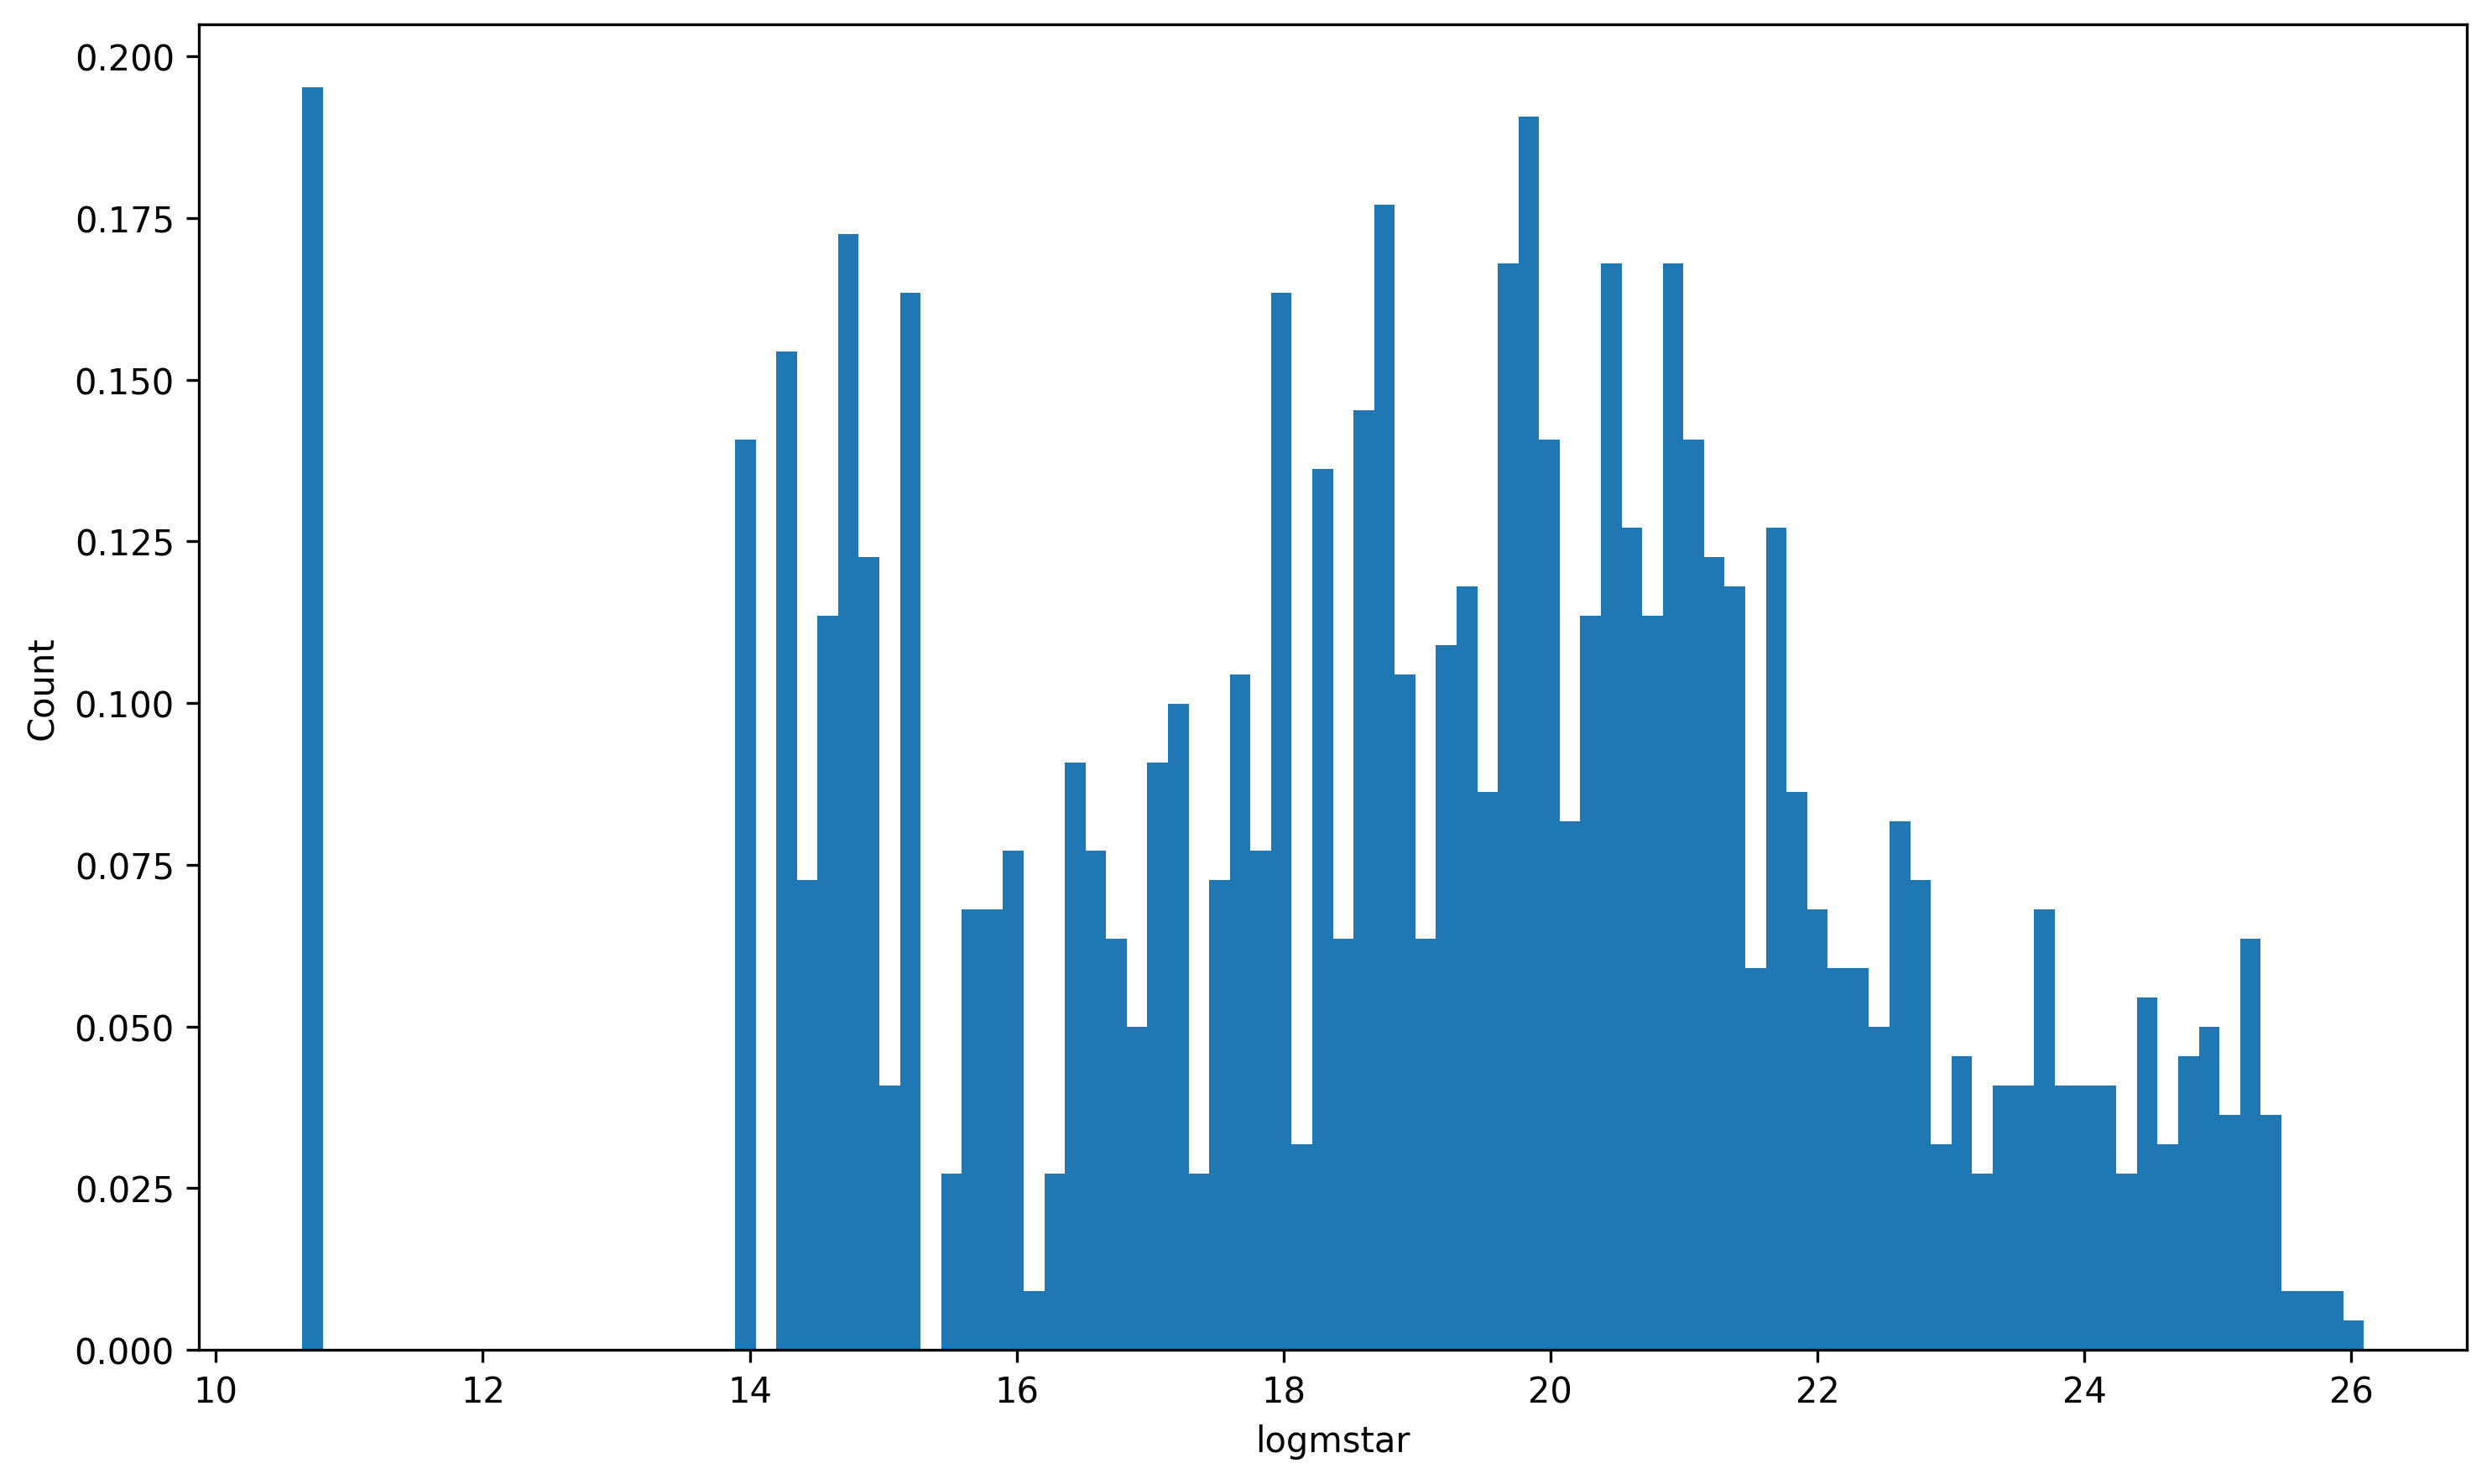

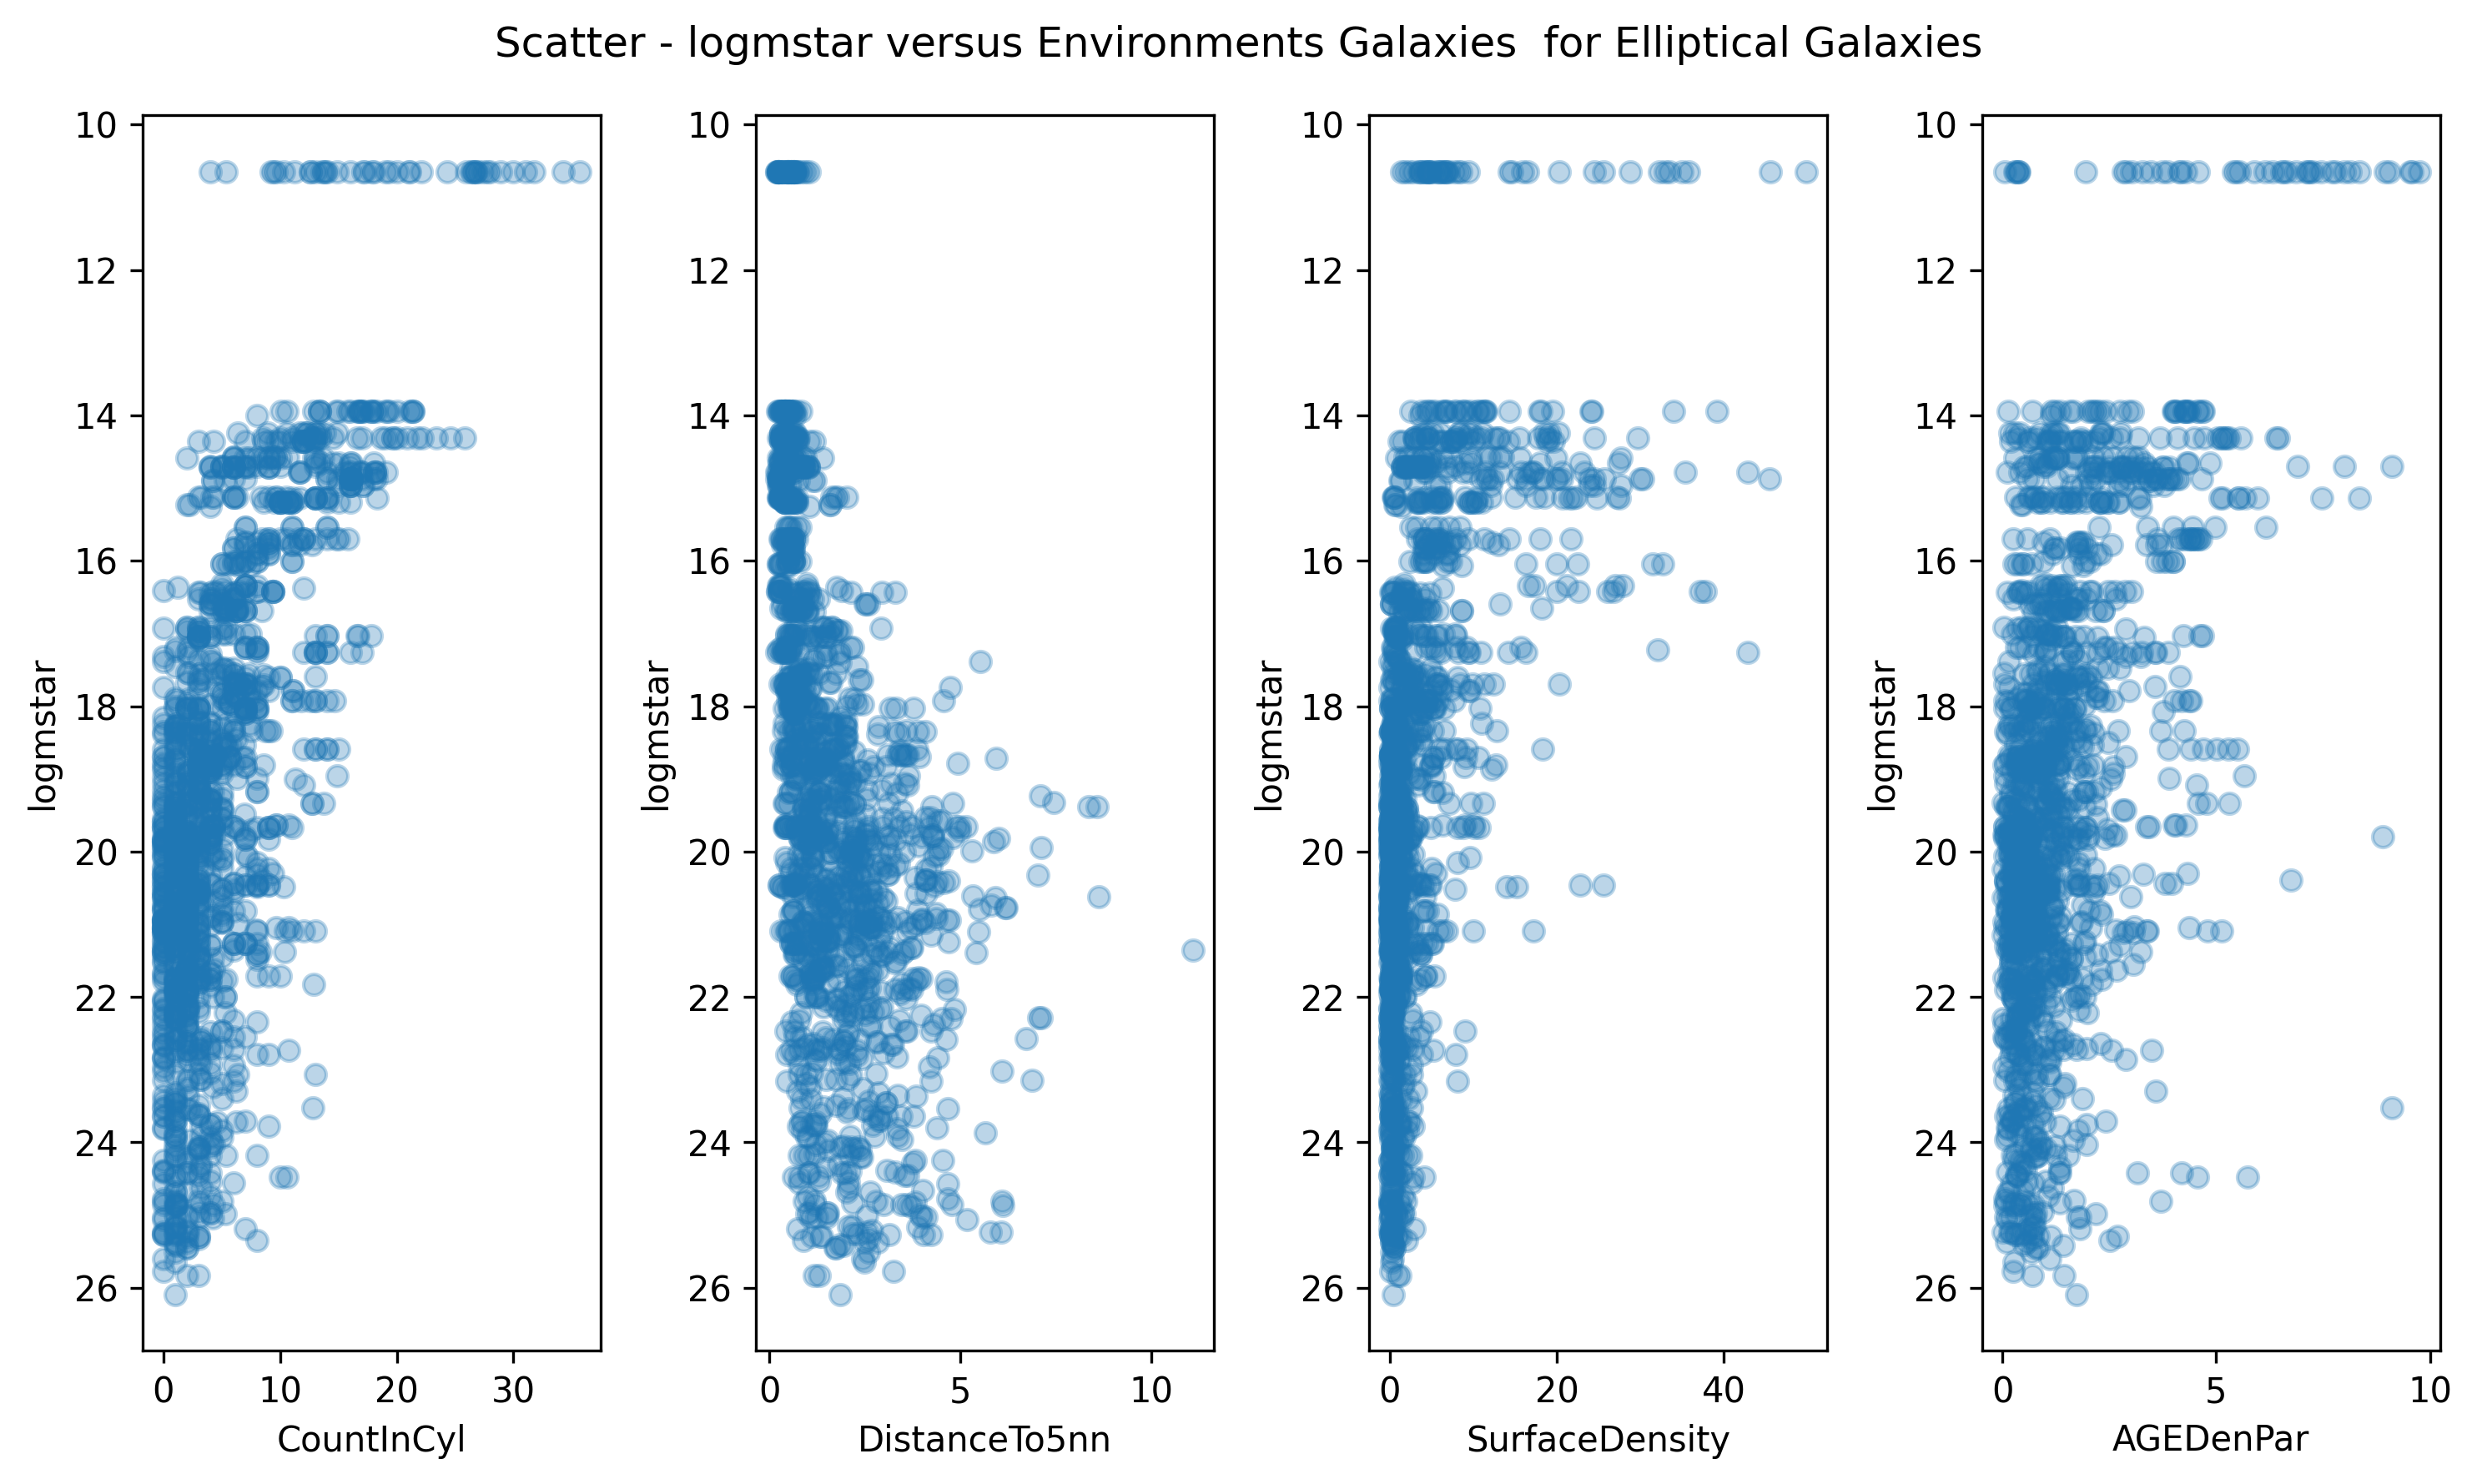

10.644666423255591
26.094531411057616
Pearson Correlation x: CountInCyl y: logmstar Correlation : -0.6989934339719918 T-Test : 1.3270837920285834e-209
Spearman Correlation x: CountInCyl y: logmstar Correlation : -0.65371563958552 T-Test : 1.3478300510227875e-174
Linear Regresion x: CountInCyl y: logmstar slope : -0.4152559747408353 Intercept 21.33355663042093 Correlation -0.6989934339719918 Wald test 1.3270837920274544e-209 0.01125826932519733
Pearson Correlation x: DistanceTo5nn y: logmstar Correlation : 0.49262880150060484 T-Test : 4.7567985632984053e-88
Spearman Correlation x: DistanceTo5nn y: logmstar Correlation : 0.6341202705617109 T-Test : 3.0033813725355437e-161
Linear Regresion x: DistanceTo5nn y: logmstar slope : 1.200550536997583 Intercept 17.0568639031356 Correlation 0.4926288015006047 Wald test 4.7567985632954976e-88 0.05620105476471556
Pearson Correlation x: SurfaceDensity y: logmstar Correlation : -0.5369080720026931 T-Test : 2.772127563688857e-107
Spearman Correlation x

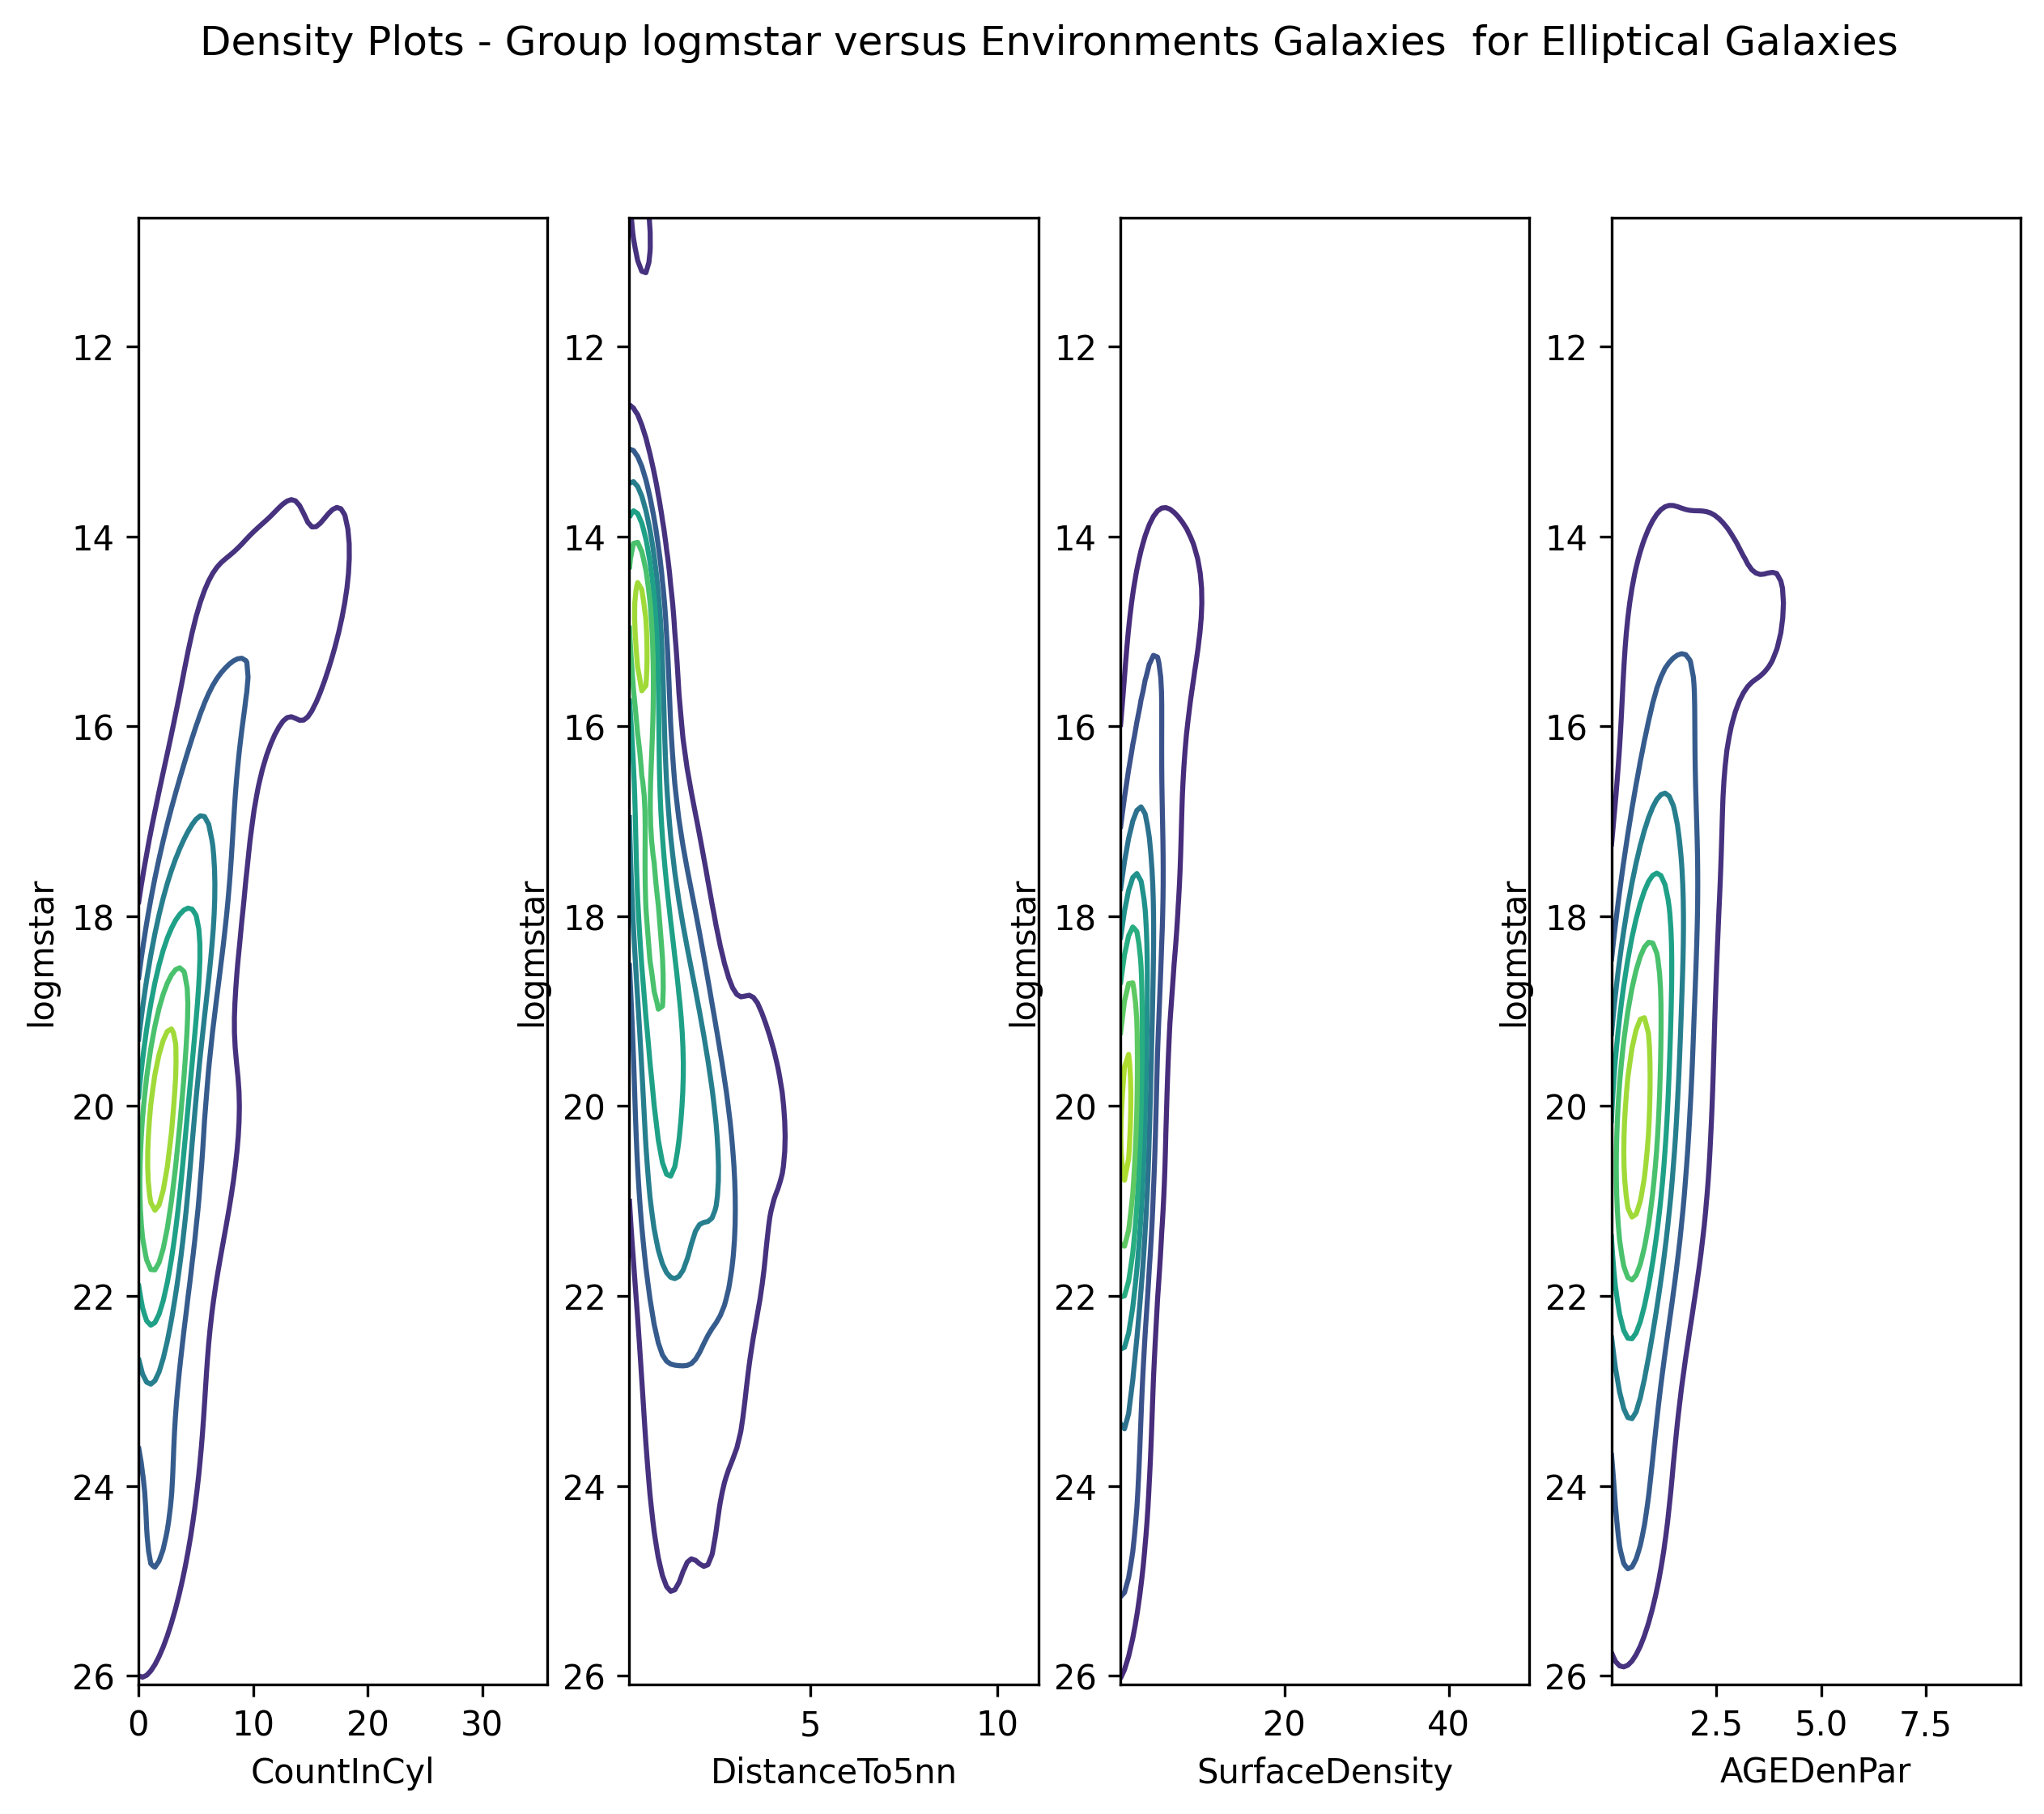

 yfield logmstar ymin 10.644666423255591 ymax 26.094531411057616

 xfield CountInCyl xmin 0.0 xmax 35.69200134277344
 xfield CountInCyl log values - xmin -4.605170249938965 xmax 3.575206756591797
Log Pearson Correlation x: CountInCyl y: logmstar Correlation : -0.65371563958552 T-Test : 1.3478300510227875e-174
Log Spearman Correlation x: CountInCyl y: logmstar Correlation : -0.4716016567344904 T-Test : 7.340006992411414e-80
Log Linear Regresion x: CountInCyl y: logmstar slope : -0.7795014757071479 Intercept 19.66752954658417 Correlation -0.4716016567344901 Wald test 7.340006992419682e-80 0.03862446550795281
 xfield DistanceTo5nn xmin 0.1850000023841858 xmax 11.090999603271484
 xfield DistanceTo5nn log values - xmin -1.6347557306289673 xmax 2.4070351123809814
Log Pearson Correlation x: DistanceTo5nn y: logmstar Correlation : 0.6341202705617109 T-Test : 3.0033813725355437e-161
Log Spearman Correlation x: DistanceTo5nn y: logmstar Correlation : 0.6246859349441616 T-Test : 3.680664428472720

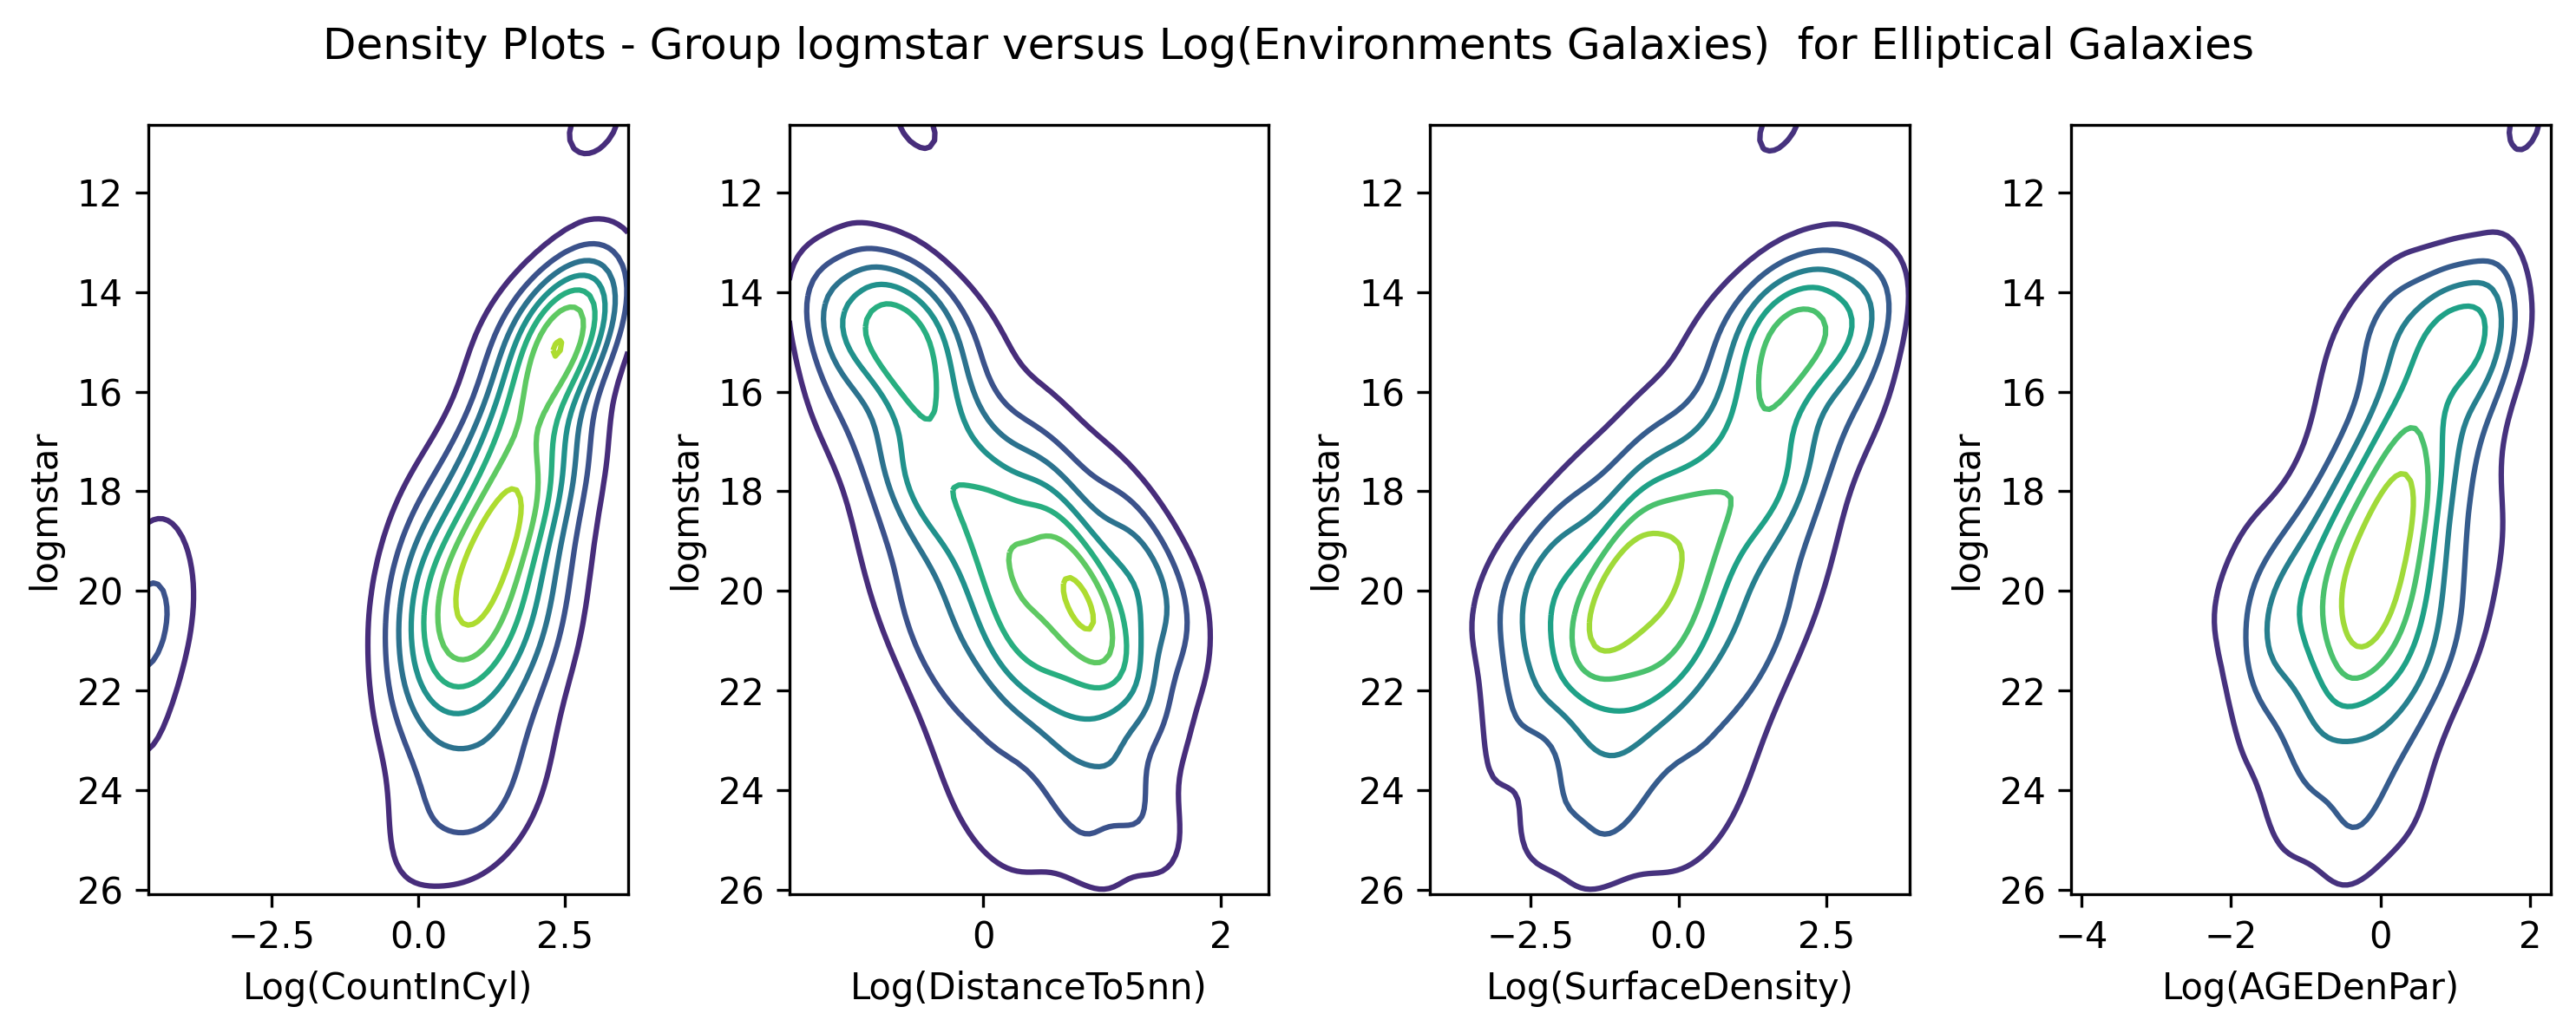

KeyError: 'uminusr'

In [3]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd


ForGroup = Table.read('../../GAMA_DATA/G3CFoFGroupv10.fits')
print(f"ForGroup : {len(ForGroup)}")
## Clean Data

GroupGal = Table.read('../../GAMA_DATA/G3CGalv10.fits')
# Clean data
GroupGal = GroupGal[GroupGal['GroupID'] > 0 ]
print(f"GroupGal : {len(GroupGal)}")

StellarMasses = Table.read('../../GAMA_DATA/StellarMassesv19.fits')
# Clean Data
#StellarMasses = StellarMasses[StellarMasses['uminusr'] > 0.001]
#StellarMasses = StellarMasses[StellarMasses['logmstar'] > 0.001]
#StellarMasses = StellarMasses[StellarMasses['metal'] > 0.001]


StellarMasses = StellarMasses[StellarMasses['uminusr'] > 0.01]
StellarMasses = StellarMasses[StellarMasses['logmstar'] > 0.01]
StellarMasses = StellarMasses[StellarMasses['metal'] > 0.01]
print(f"StellarMasses : {len(StellarMasses)}")


envMeasures = Table.read('../../GAMA_DATA/EnvironmentMeasuresv05.fits')
print(f"EnvMeasures : {len(envMeasures)}")
# Clean Data
envMeasures = envMeasures[envMeasures['SurfaceDensity'] < 50]
envMeasures = envMeasures[envMeasures['AGEDenParFlag'] == 0]
envMeasures = envMeasures[envMeasures['CountInCylFlag'] == 0]


visualMorph = Table.read('../../GAMA_Data/VisualMorphologyv03.fits')
print(f"visualMorph : {len(visualMorph)}")
## Clean Data
visualMorph = visualMorph[visualMorph['ELLIPTICAL_CODE'] == 1]


DataLocalGroup = join(GroupGal,StellarMasses,keys='CATAID',join_type='inner')
print(f"Join GroupGal & StellarMasses {len(DataLocalGroup)}")
print('GroupGal & StellarMasses')
print(DataLocalGroup.colnames)

import math

# Sum uminsur, logmstar and metal over Local Group
DLG_Groups = DataLocalGroup.group_by('GroupID')
#GroupData = DLG_Groups['GroupID','uminusr','logmstar','metal'].groups.aggregate(np.sum)
GroupData = DLG_Groups['GroupID','logmstar'].groups.aggregate(lambda x: -2.5*math.log(np.sum(10**(-0.4 * x))))
print(GroupData)


print('GroupData')
print(GroupData.colnames)
print('GroupGal')
print(GroupGal.colnames)

FinalData = join(GroupGal,GroupData,keys='GroupID',join_type='inner')
print(FinalData)
print(FinalData.colnames)

FinalData = join(FinalData,envMeasures,keys='CATAID',join_type='inner')
print('Joining Environment Measures '+str(len(FinalData)))
#print(FinalData.colnames)

FinalData = join(FinalData,visualMorph,keys='CATAID',join_type='inner')
print('Joining Visual Morph '+str(len(FinalData)))


alphaVal = .3
binCount = 100

RErange = FinalData
#RErange = GroupData


fig = plt.figure(figsize=(10, 6), dpi=300)
#fig.suptitle('Plot - Redness versus Environments Galaxies  for Elliptical Galaxies')
xfields = ['logmstar']


xn = np.linspace(0,100,100)
i = 1
for xfield in xfields :
    ax = fig.add_subplot(len(xfields),1,i)
    i += 1
    ax.set_ylabel('Count')
    ax.set_xlabel(xfield)
    ax.hist(RErange[xfield],bins=binCount, density=True)
fig.tight_layout()
plt.show()

                                                             
yfield = 'logmstar'

fig = plt.figure(figsize=(10, 6), dpi=300)
fig.suptitle('Scatter - '+yfield+' versus Environments Galaxies  for Elliptical Galaxies')
xfields = ['CountInCyl','DistanceTo5nn','SurfaceDensity','AGEDenPar']
i = 1
y = RErange[yfield]
for xfield in xfields :
    ax = fig.add_subplot(1, len(xfields), i)
    i += 1           
    ax.set_ylabel(yfield)
    ax.set_xlabel(xfield)
    ax.invert_yaxis()
    #ax.set_ylim([-5,7])
    x = RErange[xfield]
    ax.scatter(x,y,alpha=alphaVal,label=xfield)        
#fig.legend(loc="upper right")
fig.tight_layout()
#fig.savefig('../../ChartsPlots/RedScatterEnvironments.png', dpi=300, bbox_inches='tight')                      
plt.show()

fig = plt.figure(figsize=(10, 8), dpi=300)
fig.suptitle('Density Plots - Group '+yfield+' versus Environments Galaxies  for Elliptical Galaxies')
xfields = ['CountInCyl','DistanceTo5nn','SurfaceDensity','AGEDenPar']
#xfields = ['GalData.CountInCyl','GalData.DistanceTo5nn','GalData.SurfaceDensity','GalData.AGEDenPar']      
y = RErange[yfield]
ymin = min(y)
print(ymin)
ymax = max(y)
print(ymax)
for i,xfield in enumerate(xfields,1) :
    x = RErange[xfield]
    xmin = min(x)
    xmax = max(x)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    ax = fig.add_subplot(1, len(xfields), i)
    ax.set_ylabel(yfield)
    ax.set_xlabel(xfield)
    ax.invert_yaxis()
    #ax.set_ylim([-6,7])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
    #ax.imshow(np.rot90(Z), cmap='PuBu',extent=[xmin, xmax, ymin, ymax])
    #ax.imshow(np.rot90(Z), cmap='PuBu')
    ax.contour(X, Y, Z)
    #ax.plot(x, y, 'k.', markersize=2)
    #ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    r, p = stats.pearsonr(x,y)
    print(f"Pearson Correlation x: {xfield} y: {yfield} Correlation : {r} T-Test : {p}")
    r, p = stats.spearmanr(x,y)
    print(f"Spearman Correlation x: {xfield} y: {yfield} Correlation : {r} T-Test : {p}")
    m, c, r, p, se = stats.linregress(x,y)
    print(f"Linear Regresion x: {xfield} y: {yfield} slope : {m} Intercept {c} Correlation {r} Wald test {p} {se}")
    
plt.show()                            
#fig.legend(loc="upper right")
fig.tight_layout()
#fig.savefig('../../ChartsPlots/GroupDensityTotRmagEnvironments.png', dpi=300, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(10, 4), dpi=300)
fig.suptitle('Density Plots - Group '+yfield+' versus Log(Environments Galaxies)  for Elliptical Galaxies')
#xfields = ['GalData.CountInCyl','GalData.DistanceTo5nn','GalData.SurfaceDensity','GalData.AGEDenPar']
xfields = ['CountInCyl','DistanceTo5nn','SurfaceDensity','AGEDenPar']     
y = RErange[yfield]
ymin = min(y)
ymax = max(y)
print(f" yfield {yfield} ymin {ymin} ymax {ymax}\n")
for i,xfield in enumerate(xfields,1) :
    x = RErange[xfield]
    xmin = min(x)
    xmax = max(x)
    print(f" xfield {xfield} xmin {xmin} xmax {xmax}")
    x = np.log(RErange[xfield]+0.01)
    xmin = min(x)
    xmax = max(x)
    print(f" xfield {xfield} log values - xmin {xmin} xmax {xmax}")
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    ax = fig.add_subplot(1, len(xfields), i)
    ax.set_ylabel(yfield)
    ax.set_xlabel('Log('+xfield+')')
    ax.invert_yaxis()
    #ax.set_ylim([-6,7.5])              
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
    #ax.imshow(np.rot90(Z), cmap='PuBu',extent=[xmin, xmax, ymin, ymax])
    
    #ax.imshow(np.rot90(Z), cmap='PuBu')
    ax.contour(X, Y, Z)  
    #ax.plot(x, y, 'k.', markersize=2)
    
    #ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    r, p = stats.spearmanr(x,y)
    print(f"Log Pearson Correlation x: {xfield} y: {yfield} Correlation : {r} T-Test : {p}")
    m, c, r, p, se = stats.linregress(x,y)
    print(f"Log Spearman Correlation x: {xfield} y: {yfield} Correlation : {r} T-Test : {p}")
    r, p = stats.pearsonr(x,y)
    print(f"Log Linear Regresion x: {xfield} y: {yfield} slope : {m} Intercept {c} Correlation {r} Wald test {p} {se}")
#fig.legend(loc="upper right")
fig.tight_layout()
fig.savefig('../../ChartsPlots/GroupDensity-Sum-logmstar-Log-Environments.png', dpi=300, bbox_inches='tight')
plt.show()



    



